In [1]:
import retire_nonconvex as retire
import numpy as np
import numpy.random as rgt
import pandas as pd

In [2]:
n, p = 400, 200 
itcp, beta, true_loc = 2, np.zeros(p), np.zeros(p)
beta[:19] = [1.8, 0, 1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.4, 0, -1.6, 0, -1.8] #s = 10
true_active_set = np.where(beta!=0)[0]  
true_loc[true_active_set] = 1           

cov_matrix = np.zeros((p,p))
for i in range(p):
    for j in range(p):
        cov_matrix[i,j] = 0.5**abs(i-j)

In [3]:
def sim(tau_input=0.5, quantile=0, expectile=0, M=10, robust=(n/np.log(n*p))**0.5, penalty="L1",\
        noise_type='normal', model_type='model1'):
    print('model_type=',model_type, ' noise_type=',noise_type, ' robust=',robust, ' penalty=', penalty)
    print("tau=",tau_input, ' expectile=',expectile, ' quantile=',quantile, ' M=', M, '\n')
    l2loss_min_vec, l2loss_1se_vec, TPR_min_vec, TPR_1se_vec, FPR_min_vec, FPR_1se_vec = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)
    for m in range(M):
        rgt.seed(100+m)
        X = rgt.multivariate_normal(np.zeros(p), cov_matrix, size = n)
        
        if noise_type == 'normal':
            noise = rgt.normal(0,2**0.5,n) #sd=sqrt(2)
        elif noise_type == 't':
            noise = rgt.standard_t(2.1,n)
        else:
            raise ValueError("noise_type must be either normal, t")
            
        if model_type == 'model1':
            Y = itcp + X.dot(beta) + noise                                        #Homoscedastic 
        elif model_type == 'model2':
            Y = itcp + X.dot(beta) + (0.5 + 0.5*abs(X[:,-1]))*(noise - quantile)  #Quantile Hetero
        elif model_type == 'model3':
            Y = itcp + X.dot(beta) + (0.5 + 0.5*abs(X[:,-1]))*(noise - expectile) #Expectile Hetero
        else:
            raise ValueError("model_type must be either model1, model2, model3")
        
        temp = retire.cv(X,Y)               
        result_temp = temp.fit(tau_input,robust=robust, scale_invariant=True, penalty=penalty, 
                 nfolds=10, standardize=True, adjust=True, CV_plot=True, CV_rule = 'both')  
        TP_min=TP_1se=FP_min=FP_1se =l2loss_min=l2loss_1se= np.nan        
        if result_temp['CV_rule']=='both' or result_temp['CV_rule']=='min':
            TP_min = ((result_temp['fit_result_min']['cv_beta']!=0)[1:] * true_loc).sum()  
            FP_min = result_temp['size_min'] - (result_temp['fit_result_min']['cv_beta']!=0)[0] - TP_min
            l2loss_min = (np.sum((result_temp['fit_result_min']['cv_beta'][1:] - beta)**2) + (result_temp['fit_result_min']['cv_beta'][0]-itcp)**2)**0.5 
            l2loss_min_vec[m] = l2loss_min            
        if result_temp['CV_rule']=='both' or result_temp['CV_rule']=='1se':
            TP_1se = ((result_temp['fit_result_1se']['cv_beta']!=0)[1:] * true_loc).sum()       
            FP_1se = result_temp['size_1se'] - (result_temp['fit_result_1se']['cv_beta']!=0)[0] - TP_1se
            l2loss_1se = (np.sum((result_temp['fit_result_1se']['cv_beta'][1:] - beta)**2) + (result_temp['fit_result_1se']['cv_beta'][0]-itcp)**2)**0.5 
            l2loss_1se_vec[m] = l2loss_1se      
        TPR_min, TPR_1se, FPR_min, FPR_1se = TP_min/len(true_active_set), TP_1se/len(true_active_set), FP_min/(p-len(true_active_set)), FP_1se/(p-len(true_active_set))
        TPR_min_vec[m], TPR_1se_vec[m], FPR_min_vec[m], FPR_1se_vec[m] = TPR_min, TPR_1se, FPR_min, FPR_1se       
        print('l2loss_min:' ,round(l2loss_min,3),' TPR_min:',round(TPR_min,3),' FPR_min:' ,round(FPR_min,3),\
              ' l2loss_1se:' ,round(l2loss_1se,3),' TPR_1se:',round(TPR_1se,3), ' FPR_1se:',round(FPR_1se,3))        

    data_min = {'l2loss_min':l2loss_min_vec, 'TPR_min': TPR_min_vec, 'FPR_min': FPR_min_vec }
    data_1se = {'l2loss_1se':l2loss_1se_vec, 'TPR_1se': TPR_1se_vec, 'FPR_1se': FPR_1se_vec }
    df_min = pd.DataFrame(data_min)
    df_1se = pd.DataFrame(data_1se)
    df = pd.concat([df_min,df_1se],axis = 1)
    return(df)

In [4]:
M=1                                #number of repetition
model_type = 'model3'              #'model1' or 'model2' or 'model3'
tau_input = 0.5                    #0.5 or 0.8
noise_type = 'normal'              #'normal' or 't'
quantile = 0                       #depends on noise type and tau level
expectile = 0.0                    #depends on noise type and tau level
robust = (n/np.log(n*p))**0.5      #theoretic scale (n/np.log(n*p))**0.5 

### A: L1 penalty

In [5]:
penalty = "L1"                     

model_type= model3  noise_type= normal  robust= 5.952332996461553  penalty= L1
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



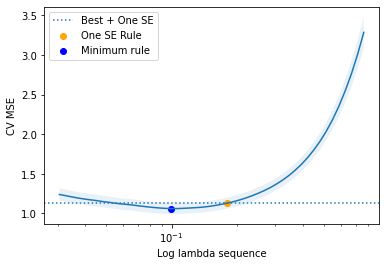

l2loss_min: 0.347  TPR_min: 1.0  FPR_min: 0.105  l2loss_1se: 0.445  TPR_1se: 1.0  FPR_1se: 0.016


In [6]:
df = sim(tau_input, quantile, expectile, M, robust, penalty, noise_type, model_type)

### B: SCAD penalty

In [7]:
penalty = "SCAD"                     

model_type= model3  noise_type= normal  robust= 5.952332996461553  penalty= SCAD
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



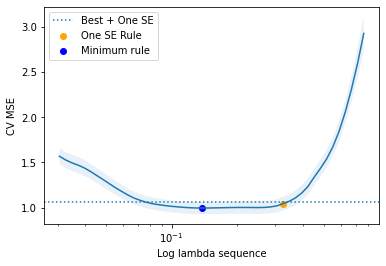

l2loss_min: 0.23  TPR_min: 1.0  FPR_min: 0.026  l2loss_1se: 0.338  TPR_1se: 1.0  FPR_1se: 0.0


In [8]:
df = sim(tau_input, quantile, expectile, M, robust, penalty, noise_type, model_type)

### C: MCP

In [9]:
penalty = "MCP"                     

model_type= model3  noise_type= normal  robust= 5.952332996461553  penalty= MCP
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



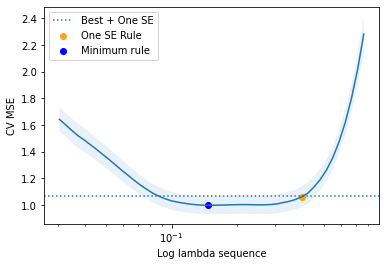

l2loss_min: 0.242  TPR_min: 1.0  FPR_min: 0.016  l2loss_1se: 0.365  TPR_1se: 1.0  FPR_1se: 0.0


In [10]:
df = sim(tau_input, quantile, expectile, M, robust, penalty, noise_type, model_type)

### D: Capped L1 penalty

In [11]:
penalty = "CappedL1"                     

model_type= model3  noise_type= normal  robust= 5.952332996461553  penalty= CappedL1
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



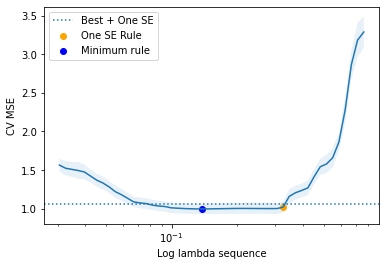

l2loss_min: 0.23  TPR_min: 1.0  FPR_min: 0.026  l2loss_1se: 0.209  TPR_1se: 1.0  FPR_1se: 0.0


In [12]:
df = sim(tau_input, quantile, expectile, M, robust, penalty, noise_type, model_type)